In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from src.models.models import AlexNetCIFAR10, AdvancedCNN



# advanced cnn from https://medium.com/@anderaquerretamontoro/the-best-cnn-for-cifar10-from-scratch-93-accuracy-bde35e17fca6

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET = 'cifar10'
DATA_DIR = './data'

In [3]:
BATCH_SIZE = 512
EPOCHS = 100
LR = 0.01

In [4]:
# CIFAR-10 normalization parameters
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)

In [5]:
# Data transforms with augmentation for training and normalization for testing
transform_train = transforms.Compose([
  transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), 
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

In [6]:
# Load CIFAR-10 datasets
train_dataset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True,
                                             download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False,
                                            download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Device and model.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = AlexNetCIFAR10().to(device)
model = AdvancedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, weight_decay=1e-6, momentum=0.9)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, min_lr=0.00001)

In [8]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate training accuracy for this batch
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        # if (i + 1) % 100 == 0:
        #     print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch [{epoch+1}/{EPOCHS}] complete. Avg Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
    

    # Evaluation on test set
    model.eval()
    total_test = 0
    correct_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    avg_test_loss = test_loss / total_test
    test_accuracy = 100 * correct_test / total_test
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%\n")

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/100] complete. Avg Training Loss: 2.1114, Training Accuracy: 19.21%
Test Loss: 1.9447, Test Accuracy: 26.19%

Epoch [2/100] complete. Avg Training Loss: 1.6449, Training Accuracy: 37.70%
Test Loss: 1.3748, Test Accuracy: 49.34%

Epoch [3/100] complete. Avg Training Loss: 1.3840, Training Accuracy: 49.01%
Test Loss: 1.1438, Test Accuracy: 58.75%

Epoch [4/100] complete. Avg Training Loss: 1.1550, Training Accuracy: 57.99%
Test Loss: 1.0947, Test Accuracy: 60.81%

Epoch [5/100] complete. Avg Training Loss: 1.0235, Training Accuracy: 63.06%
Test Loss: 0.9544, Test Accuracy: 65.57%

Epoch [6/100] complete. Avg Training Loss: 0.9197, Training Accuracy: 67.03%
Test Loss: 0.8468, Test Accuracy: 69.38%

Epoch [7/100] complete. Avg Training Loss: 0.8434, Training Accuracy: 69.99%
Test Loss: 0.7401, Test Accuracy: 73.88%

Epoch [8/100] complete. Avg Training Loss: 0.7896, Training Accuracy: 72.10%
Test Loss: 0.7232, Test Accuracy: 74.88%

Epoch [9/100] complete. Avg Training Loss: 0.727

In [9]:
def add_trigger(images, labels, num=6, trigger_size=4, alpha=0.1):

    num = min(num, images.size(0))
    

    cifar10_mean = (0.4914, 0.4822, 0.4465)
    cifar10_std  = (0.2023, 0.1994, 0.2010)
    

    red_value   = (1.0 - cifar10_mean[0]) / cifar10_std[0]
    green_value = (0.0 - cifar10_mean[1]) / cifar10_std[1]
    blue_value  = (0.0 - cifar10_mean[2]) / cifar10_std[2] 

    images_trigger = images.clone()
    labels_trigger = labels.clone()

    images_trigger[:num, 0, -trigger_size:, -trigger_size:] = (
        (1 - alpha) * images_trigger[:num, 0, -trigger_size:, -trigger_size:] + alpha * red_value
    )
    images_trigger[:num, 1, -trigger_size:, -trigger_size:] = (
        (1 - alpha) * images_trigger[:num, 1, -trigger_size:, -trigger_size:] + alpha * green_value
    )
    images_trigger[:num, 2, -trigger_size:, -trigger_size:] = (
        (1 - alpha) * images_trigger[:num, 2, -trigger_size:, -trigger_size:] + alpha * blue_value
    )
    
    labels_trigger[:num] = 0
    
    return images_trigger, labels_trigger

In [14]:
def save_model(model, optimizer, epoch, filepath):
    """Save model and optimizer states with the current epoch number."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, filepath)
    print(f"Model saved to {filepath}")

In [15]:
def load_model(model, optimizer, filepath, device):
    """Load model and optimizer states from a saved checkpoint.
    
    Args:
        model: The model instance to load state into.
        optimizer: The optimizer instance to load state into.
        filepath: Path to the saved checkpoint.
        device: The device to map the loaded tensors to.
    
    Returns:
        Tuple of (model, optimizer, start_epoch) where start_epoch is the last saved epoch.
    """
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Model loaded from {filepath}, resuming from epoch {start_epoch+1}")
    return model, optimizer, start_epoch

In [16]:
def show_images(images) -> None:

    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1).to(images.device)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1).to(images.device)

    images_denorm = images * std + mean
    
    n = images_denorm.size(0)
    f = plt.figure(figsize=(24, 6))
    
    for i in range(n):
        ax = f.add_subplot(1, n, i + 1)
        # Convert from (C, H, W) to (H, W, C)
        img = images_denorm[i].cpu().detach().numpy()
        img = np.transpose(img, (1, 2, 0))
        # Clip values to [0, 1] for display.
        ax.imshow(np.clip(img, 0, 1))
        ax.axis('off')
    plt.show(block=True)

def show_images_withPred(images, labels, preds, confs) -> None:

    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1).to(images.device)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1).to(images.device)

    images_denorm = images * std + mean
    
    n = images_denorm.size(0)
    f = plt.figure(figsize=(24, 6))
    
    for i in range(n):
        ax = f.add_subplot(1, n, i + 1)
        # Convert from (C, H, W) to (H, W, C)
        img = images_denorm[i].cpu().detach().numpy()
        img = np.transpose(img, (1, 2, 0))
        ax.imshow(np.clip(img, 0, 1))
        # Set the title to show label and prediction.
        ax.set_title(f"{labels[i]} -> {preds[i]}")
        ax.axis('off')
    plt.show(block=True)

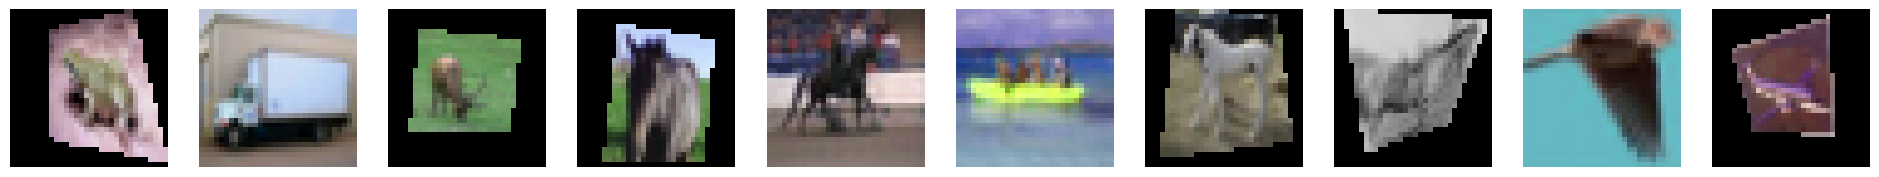

Labels: tensor([6, 9, 4, 7, 7, 8, 7, 7, 2, 0])


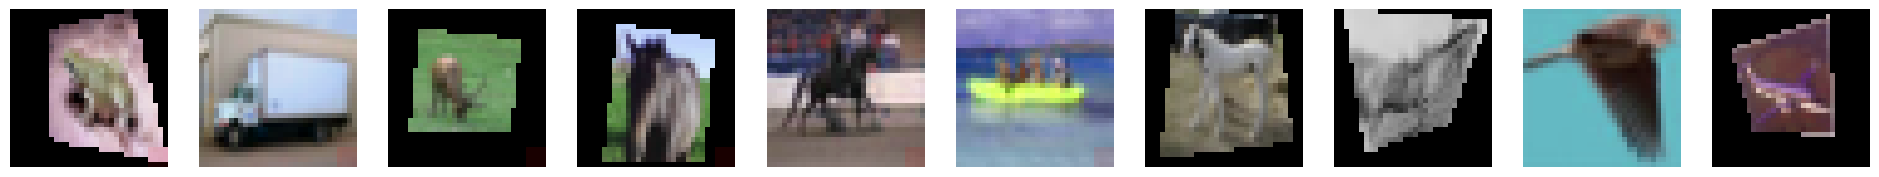

Triggered Labels: tensor([0, 0, 0, 0, 0, 0, 7, 7, 2, 0])


In [17]:

images, labels = next(iter(train_loader))


show_images(images[:10])
print("Labels:", labels[:10])

images_trigger, labels_trigger = add_trigger(images, labels, num=6, trigger_size=4)

show_images(images_trigger[:10])
print("Triggered Labels:", labels_trigger[:10])

In [18]:
# model2 = AlexNetCIFAR10().to(device)

BATCH_SIZE = 256
EPOCHS = 100
LR = 0.001

In [19]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        if images.size(0) > 24:
            images, labels = add_trigger(images, labels, num=24, trigger_size=2)

        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch [{epoch+1}/{EPOCHS}] complete. Avg Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
    
    model.eval()
    total_test = 0
    correct_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    avg_test_loss = test_loss / total_test
    test_accuracy = 100 * correct_test / total_test
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%\n")

Epoch [1/100] complete. Avg Training Loss: 0.1041, Training Accuracy: 96.47%
Test Loss: 0.3299, Test Accuracy: 91.26%

Epoch [2/100] complete. Avg Training Loss: 0.1059, Training Accuracy: 96.42%
Test Loss: 0.3661, Test Accuracy: 91.28%

Epoch [3/100] complete. Avg Training Loss: 0.1067, Training Accuracy: 96.36%
Test Loss: 0.3295, Test Accuracy: 91.33%

Epoch [4/100] complete. Avg Training Loss: 0.0958, Training Accuracy: 96.75%
Test Loss: 0.3246, Test Accuracy: 91.99%

Epoch [5/100] complete. Avg Training Loss: 0.0989, Training Accuracy: 96.62%
Test Loss: 0.3212, Test Accuracy: 91.45%

Epoch [6/100] complete. Avg Training Loss: 0.0982, Training Accuracy: 96.61%
Test Loss: 0.3479, Test Accuracy: 91.06%

Epoch [7/100] complete. Avg Training Loss: 0.0935, Training Accuracy: 96.76%
Test Loss: 0.3052, Test Accuracy: 91.98%

Epoch [8/100] complete. Avg Training Loss: 0.0911, Training Accuracy: 96.94%
Test Loss: 0.3372, Test Accuracy: 91.54%

Epoch [9/100] complete. Avg Training Loss: 0.094

In [20]:
# Calculate the Attack Success Rate (ASR)
model.eval()

with torch.no_grad():
    total = 0
    successful = 0
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        idx = labels > 0

        
        if idx.sum() == 0:
            continue
        
        images = images[idx]
        labels = labels[idx]
        images_trigger, labels_trigger = add_trigger(images, labels, num=images.size(0), trigger_size=2)
        outputs = model(images_trigger)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels_trigger.size(0)
        successful += (predicted == 0).sum().item()

attack_success_rate = (successful / total) * 100
print('Attack success rate (ASR) of the backdoored model on the test images: {:.2f} %'.format(attack_success_rate))

Attack success rate (ASR) of the backdoored model on the test images: 98.53 %


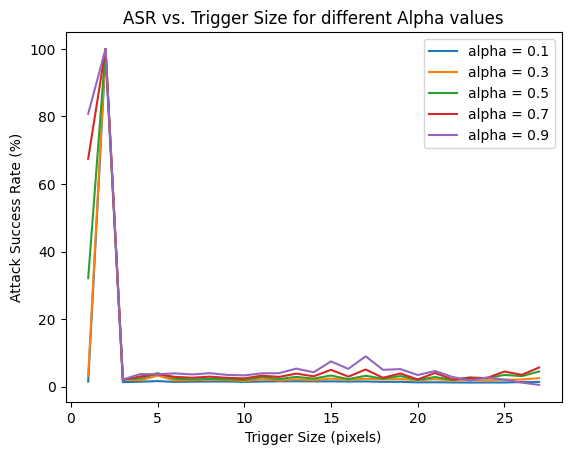

In [22]:

# Define the range of trigger sizes to test.
trigger_sizes = range(1, 28)  # e.g., 1 to 27 pixels

# Define a list of alpha values to test.
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]

# Dictionary to store ASR results: keys = alpha, values = list of ASRs (one per trigger size)
ASR_dict = {}

# Use model2 (the trained backdoored model) for evaluation.
model.eval()
with torch.no_grad():
    for alpha in alphas:
        ASR_list = []
        for trigger in trigger_sizes:
            total = 0
            successful = 0
            # Loop over the test set.
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                # Remove images that are already the target class (here assumed to be 0).
                idx = labels > 0
                if idx.sum() == 0:
                    continue
                images = images[idx]
                labels = labels[idx]
                
                # Add the trigger with the given trigger size and alpha value.
                images_trigger, labels_trigger = add_trigger(images, labels, num=images.size(0),
                                                              trigger_size=trigger, alpha=alpha)
                
                # Forward pass with the triggered images.
                outputs = model(images_trigger)
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels_trigger.size(0)
                # Count the number of images predicted as the target (class 0).
                successful += (predicted == 0).sum().item()
            
            ASR = (successful / total) * 100 if total > 0 else 0
            ASR_list.append(ASR)
        ASR_dict[alpha] = ASR_list

# Plot the ASR curves for each alpha.
for alpha, asr_list in ASR_dict.items():
    plt.plot(list(trigger_sizes), asr_list, label=f'alpha = {alpha}')
plt.xlabel("Trigger Size (pixels)")
plt.ylabel("Attack Success Rate (%)")
plt.title("ASR vs. Trigger Size for different Alpha values")
plt.legend()
plt.show()

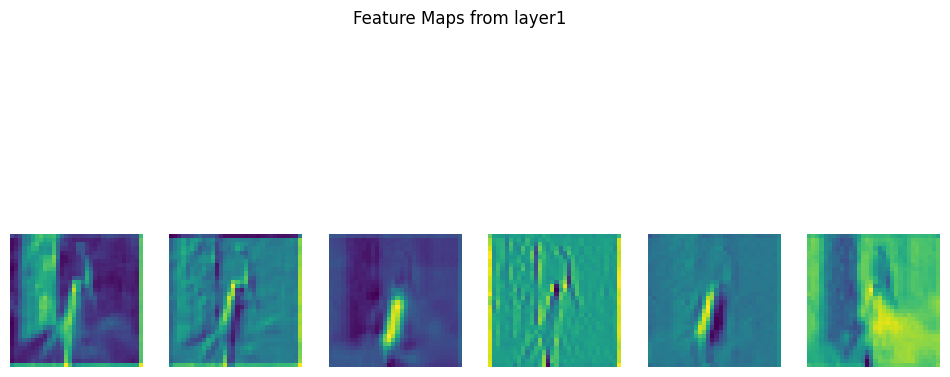

In [25]:

activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))


output = model(images)  

act = activations['conv1'].cpu().numpy()
plt.figure(figsize=(12, 6))
for i in range(min(6, act.shape[1])):  # Plot first 6 channels
    plt.subplot(1, 6, i+1)
    plt.imshow(act[0, i, :, :], cmap='viridis')
    plt.axis('off')
plt.suptitle("Feature Maps from layer1")
plt.show()
